# Tweet Disaster Prediction

In [1]:
import os
os.listdir()

['.config', 'sample_data']

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [0]:
12.47

12.47

# Data


>Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). Soure: https://www.kaggle.com/c/nlp-getting-started/overview

In [0]:
df = pd.read_csv('train.csv')

In [0]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Text(0.5, 1.0, 'Tweet Distribution')

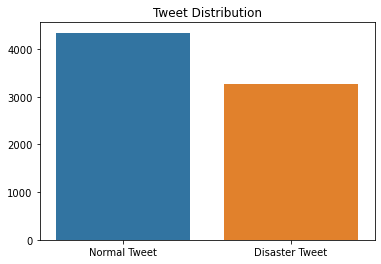

In [0]:
sns.barplot(x=['Normal Tweet', 'Disaster Tweet'],
           y=df['target'].value_counts().values)
plt.title('Tweet Distribution')

# Model

In [0]:
from fastai2.text.all import *
from nbdev.showdoc import *

In [0]:
path = Path()
path.ls()

(#4) [Path('train.csv'),Path('tweet_disaster prediction model.ipynb'),Path('.ipynb_checkpoints'),Path('models')]

In [0]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [0]:
df.shape

(7613, 5)

Let's shuffle the data and set 20% of the data for model validation

In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
len(df) *0.8

6090.400000000001

In [0]:
df['is_valid'] = False

In [0]:
df.loc[:int(len(df)*0.8),'is_valid'] = True

In [0]:
df['is_valid'].value_counts()

True     6091
False    1522
Name: is_valid, dtype: int64

In [0]:
df['text'][5000]

'Obama declares disaster for typhoon-devastated Saipan #Worldnews http://t.co/9NYXjndoRA'

In [0]:
dbunch_lm = TextDataLoaders.from_df(df, text_col='text', 
                                    label_col='target', 
                                    path=path, is_lm=True,
                                    valid_col='is_valid')

In [0]:
dbunch_lm.train_ds[0]

(TensorText([   2,    8,  377,   10,    8,  542,   19,  431,  420,    0,    0,   42,
           71,    8, 2907,    0,    0,   37,    8,    0,    8, 2260,   23,    0,
           44,   45,   10,    9,    9,   11,    9,    0]),)

In [0]:
dbunch_lm.vocab[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 '/',
 ':',
 't.co',
 'http',
 '#',
 'the',
 '.',
 'a',
 'in',
 'to',
 'of']

In [0]:
dbunch_lm.show_batch()

,text,text_
0,xxbos xxmaj when you xxunk already know you 're gon na drown in school this year :) http : / / t.co / xxunk xxbos # xxmaj xxunk causes # landslide in xxmaj xxunk # xxmaj pakistan xxmaj damage to 20 homes xxunk roads and xxunk # xxunk http : / / t.co / xxunk xxbos xxmaj get access to the most xxunk sources of threat information right out of the box,xxmaj when you xxunk already know you 're gon na drown in school this year :) http : / / t.co / xxunk xxbos # xxmaj xxunk causes # landslide in xxmaj xxunk # xxmaj pakistan xxmaj damage to 20 homes xxunk roads and xxunk # xxunk http : / / t.co / xxunk xxbos xxmaj get access to the most xxunk sources of threat information right out of the box .
1,killing this dude and tea bagging the dead body at this point xxbos crushed a 6 mile run tonight . awesome xxbos xxmaj reality xxmaj training : xxmaj train falls off elevated tracks during windstorm http : / / t.co / xxunk # xxmaj paramedic # xxup ems xxbos # nowplaying xxmaj school xxmaj of xxmaj seven xxmaj bells - xxmaj windstorm # xxup xxunk xxbos i wish that the earth sea,this dude and tea bagging the dead body at this point xxbos crushed a 6 mile run tonight . awesome xxbos xxmaj reality xxmaj training : xxmaj train falls off elevated tracks during windstorm http : / / t.co / xxunk # xxmaj paramedic # xxup ems xxbos # nowplaying xxmaj school xxmaj of xxmaj seven xxmaj bells - xxmaj windstorm # xxup xxunk xxbos i wish that the earth sea and
2,xxup u.s xxmaj national xxmaj park xxmaj services xxmaj tonto xxmaj national xxmaj forest : xxmaj stop the xxmaj annihilation of the xxmaj salt xxmaj river xxmaj wild xxmaj horse … https : / / t.co / xxunk via @change xxbos xxunk xxmaj another shooting in a movie theater this is getting more xxunk but xxmaj i 'm glad they got the xxunk & & no casualties . xxbos xxmaj xxunk a,u.s xxmaj national xxmaj park xxmaj services xxmaj tonto xxmaj national xxmaj forest : xxmaj stop the xxmaj annihilation of the xxmaj salt xxmaj river xxmaj wild xxmaj horse … https : / / t.co / xxunk via @change xxbos xxunk xxmaj another shooting in a movie theater this is getting more xxunk but xxmaj i 'm glad they got the xxunk & & no casualties . xxbos xxmaj xxunk a petition
3,: / / t.co / xxunk # xxunk # management # leadership # xxunk # startup # business xxbos xxunk do n't drown xxbos xxunk xxunk xxmaj check out this # rockin preview of @claytonbryant xxmaj danger xxmaj zone xxmaj coming soon ! https : / / t.co / xxunk # artistsunited xxbos xxmaj iûªve seen lots ask about this xxup mt xxunk # xxmaj xxunk i asked for magic xxunk but,/ / t.co / xxunk # xxunk # management # leadership # xxunk # startup # business xxbos xxunk do n't drown xxbos xxunk xxunk xxmaj check out this # rockin preview of @claytonbryant xxmaj danger xxmaj zone xxmaj coming soon ! https : / / t.co / xxunk # artistsunited xxbos xxmaj iûªve seen lots ask about this xxup mt xxunk # xxmaj xxunk i asked for magic xxunk but not
4,t.co / xxunk xxbos xxunk hopefully it does n't electrocute your xxunk blanket lmao xxbos xxunk your lifetime odds of dying from an airplane accident are 1 in xxunk . xxbos xxunk or sunk however it may be to the xxunk land beyond the xxunk of a xxunk cobra landing xxunk upon his back ; torch and xxbos 17 dead as xxmaj afghanistan aircraft crashes : xxmaj an xxmaj afghan military helicopter,/ xxunk xxbos xxunk hopefully it does n't electrocute your xxunk blanket lmao xxbos xxunk your lifetime odds of dying from an airplane accident are 1 in xxunk . xxbos xxunk or sunk however it may be to the xxunk land beyond the xxunk of a xxunk cobra landing xxunk upon his back ; torch and xxbos 17 dead as xxmaj afghanistan aircraft crashes : xxmaj an xxmaj afghan military helicopter has
5,xxmaj how xxmaj metrics xxmaj xxunk to xxup am xxmaj best 's xxmaj property / xxmaj casualty … - xxunk http : / / t.co / xxunk xxbos xxmaj news : fedex no longer to transport bioterror germs in wake of anthrax lab mishaps http : / / t.co / xxunk x

# Language model

In [0]:
bs = 32

In [0]:
path.ls()

(#4) [Path('train.csv'),Path('tweet_disaster prediction model.ipynb'),Path('.ipynb_checkpoints'),Path('models')]

In [0]:
len(dbunch_lm.vocab)

4568

In [0]:
learn = language_model_learner(dbunch_lm, AWD_LSTM, drop_mult=0.3, 
                               metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.12022644281387329)

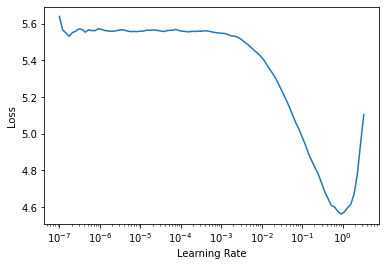

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.267512,4.748250,0.302345,115.382133,00:09


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, 2e-2, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.334154,3.816218,0.366381,45.432053,00:09
1,4.137093,3.779628,0.383203,43.799736,00:09
2,3.726204,3.519862,0.414762,33.779774,00:09
3,3.273387,3.638694,0.422765,38.042122,00:09
4,2.840678,3.873579,0.417237,48.114269,00:09
5,2.454613,3.989811,0.420972,54.044697,00:09
6,2.118985,3.996344,0.422297,54.398884,00:09
7,1.855865,4.069306,0.421038,58.516361,00:09
8,1.631469,4.039474,0.421912,56.796459,00:09
9,1.451424,4.031831,0.422355,56.364033,00:09


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = 'Car accidents'
N_WORDS = 30
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Car accidents : The Indian Express : An airplane accident happened At Always extreme # Thriller http : / / t.co / # news
Car accidents : The Indian Express : Village Youth Saved Many Lives http : / / t.co / children My car is


In [0]:
learn.save_encoder('fine_tuned_enc')

# Classifier

In [0]:
tweet_class = DataBlock(blocks=(TextBlock.from_df('text',vocab=dbunch_lm.vocab),CategoryBlock),
                       get_y = ColReader('target'),
                       get_x = ColReader('text'),
                       splitter=ColSplitter())

In [0]:
df.head(2)

,id,keyword,location,text,target,is_valid
0,2889,damage,Charlotte NC,REPORTED: HIT &amp; RUN-IN ROADWAY-PROPERTY DAMAGE at 15901 STATESVILLE RD,1,True
1,5925,harm,va,@malistkiss Sunnis continue to believe they are more righteous and they continually harm Shias. Defeats the ideals of Islam.,1,True


In [0]:
pd.crosstab(df['is_valid'],df['target'])

target,0,1
is_valid,,
False,860,662
True,3482,2609


In [0]:
dbunch_class = tweet_class.dataloaders(df,path, bs=bs, seq_len=80)

In [0]:
dbunch_class.show_batch()

,text,category
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0
2,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0
3,xxbos xxmaj strong xxmaj thunderstorm 4 xxmaj miles xxmaj north of xxmaj xxunk xxmaj moving xxup se xxmaj at 25 xxup mph . xxmaj large xxmaj hail and xxmaj wind xxmaj gusts xxmaj up to 50 xxup mph xxmaj xxunk … # arwx http : / / t.co / xxunk,1
4,xxbos xxmaj new post on my blog : http : / / t.co / xxmaj xxunk \n xxunk : \n\n xxmaj model : xxmaj cam xxmaj damage \n\n xxmaj toronto xxmaj xxunk 2014 \n\n▁ # nsfw # pussy # ass # xxunk # asian # nude # û _,0
5,xxbos xxmaj baltimore xxmaj city : xxup xxunk xxup north xxup at xxup mp xxunk ( fort xxup xxunk xxup tunnel xxup bore 3 : xxmaj collision : xxup xxunk xxup north xxup at xxup mp xxunk ( fort xxup xxunk xxup tunnel xxup bore 3 xxmaj xxunk …,1
6,xxbos # handbag # fashion # style http : / / t.co / xxunk xxmaj vintage xxmaj coach xxmaj purse xxmaj camera xxmaj bag xxmaj cross xxmaj body # xxunk \n\n $ xxunk ( 0 xxmaj xxunk ) \n û _ http : / / t.co / xxunk,0
7,xxbos 12 ' xxunk xxup cree xxup led xxmaj work xxmaj light xxmaj bar xxmaj xxunk xxmaj spot xxmaj flood xxmaj combo xxmaj diving xxmaj offroad 4wd xxmaj boat - xxmaj full readû _ http : / / t.co / xxunk http : / / t.co / xxunk,0
8,xxbos xxup severe xxup weather xxup bulletin xxmaj no . 5 \n xxup for : xxup typhoon ûï # xxunk ( soudelor ) \n xxup tropical xxup cyclone : xxup warning \n\n xxup issued xxup at xxunk xxup pm 06 … http : / / t.co / xxunk,1


In [0]:
learn = text_classifier_learner(dbunch_class, AWD_LSTM,
                                drop_mult=0.3, metrics=accuracy).to_fp16()
learn.load_encoder('fine_tuned_enc')

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=1.5848931980144698e-06)

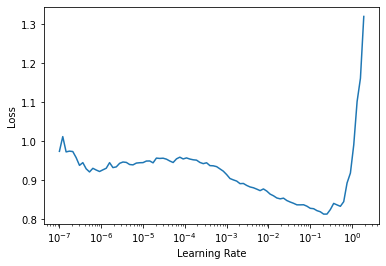

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.704973,0.508694,0.759810,00:05


In [0]:
learn.save('first')
learn.load('first')

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.608329,0.601274,0.713512,00:05
1,0.568861,0.554379,0.754556,00:05
2,0.435586,0.618796,0.757675,00:05
3,0.347951,0.634054,0.762436,00:05
4,0.284382,0.645415,0.767854,00:05


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3),moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.236459,0.734144,0.752422,00:05


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.184168,0.726901,0.757675,00:06
1,0.172427,0.725028,0.759810,00:06


In [0]:
learn.fit_one_cycle(4,slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.127019,0.748010,0.760302,00:06
1,0.132342,0.803429,0.764078,00:06
2,0.121426,0.796278,0.764735,00:06
3,0.124574,0.800234,0.771138,00:06


In [0]:
learn.predict("there's a fire emergency in my city")

('1', tensor(1), tensor([1.5999e-05, 9.9998e-01]))

In [0]:
learn.predict("What a peaceful place to live")

('0', tensor(0), tensor([0.9959, 0.0041]))

In [0]:
learn.show_results()

,text,category,category_
0,xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n\n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0,0
1,xxbos xxup info xxup u. xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 . xxup wnd : xxunk / 6 .,0,0
2,xxbos i xxmaj hate xxmaj to xxmaj talking xxmaj xxunk xxmaj with xxmaj my xxmaj xxunk … i xxmaj mean i xxmaj love xxmaj her xxmaj as xxmaj to xxmaj death xxmaj but xxmaj she xxmaj talk xxmaj so xxmaj damn xxmaj much xxmaj xxunk xxrep 3 h xxrep 3 e xxunk xxrep 3 ! xxrep 6 ?,0,0
3,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1,1
4,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1,1
5,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0,0
6,xxbos xxmaj strong xxmaj thunderstorm 4 xxmaj miles xxmaj north of xxmaj xxunk xxmaj moving xxup se xxmaj at 25 xxup mph . xxmaj large xxmaj hail and xxmaj wind xxmaj gusts xxmaj up to 50 xxup mph xxmaj xxunk … # arwx http : / / t.co / xxunk,1,1
7,xxbos # nowplaying * xxmaj cliff xxmaj richard - i xxmaj could xxmaj easily xxmaj fall ( in xxmaj love xxmaj with xxmaj you ) ( & & xxmaj xxunk ) * # xxmaj internet # xxmaj xxunk # xxmaj radio xxmaj on http : / / t.co / xxunk,0,0
8,xxbos xxmaj xxunk xxmaj hot xxmaj deals # xxunk > > http : / / t.co / xxunk xxunk xxunk xxunk xxunk xxup led xxmaj work xxmaj light xxup flood xxmaj lamp xxmaj xxunk xxmaj truck xxup suv xxup xxunk xxup aû _ http : / / t.co / xxunk,0,0


# Interpretation

In [0]:
from fastai.text.interpret import *

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.confusion_matrix()

array([[2911,  571],
       [ 823, 1786]])

In [0]:
interp.plot_top_losses(5)

,input,target,predicted,probability,loss
0,xxbos xxmaj hellfire is surrounded by desires so be careful and donûªt let your desires control you ! # xxmaj afterlife,1,0,0.9999997615814209,15.078125
1,xxbos xxmaj large rain xxunk falling in xxmaj rock xxmaj hill off xxmaj xxunk xxmaj road . # rain # xxunk # drought,0,1,0.9999959468841553,12.410160064697266
2,xxbos xxmaj fire waves and darkness,0,1,0.9999955892562866,12.332035064697266
3,xxbos xxmaj trauma xxmaj team needs to come to the xxmaj american xxmaj e - shop .,0,1,0.9999877214431763,11.312512397766113
4,xxbos @youngheroesid xxmaj lava xxmaj blast dan xxmaj power xxmaj red # pantherattack xxunk xxunk,1,0,0.9999871253967285,11.26173210144043


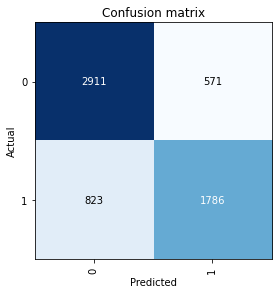

In [0]:
interp.plot_confusion_matrix()